In [ ]:
!wget https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip

--2025-12-08 14:56:27--  https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘online+retail+ii.zip’

online+retail+ii.zi     [       <=>          ]  43.51M  35.8MB/s    in 1.2s    

2025-12-08 14:56:28 (35.8 MB/s) - ‘online+retail+ii.zip’ saved [45622418]



In [ ]:
!unzip online+retail+ii.zip

Archive:  online+retail+ii.zip
 extracting: online_retail_II.xlsx   


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
df_2009 = pd.read_excel("online_retail_II.xlsx", "Year 2009-2010")
df_2010 = pd.read_excel("online_retail_II.xlsx", "Year 2010-2011")

display(f"2009 shape: {df_2009.shape}")
display(f"2010 shape: {df_2010.shape}")

'2009 shape: (525461, 8)'

'2010 shape: (541910, 8)'

In [ ]:
df = pd.concat([df_2009, df_2010])
display(f"All shape: {df.shape}")

'All shape: (1067371, 8)'

In [ ]:
df["Customer ID"].nunique()

5942

# Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,1.067371e+06,1067371,1.067371e+06,824364.000000
mean,9.938898e+00,2011-01-02 21:13:55.394028544,4.649388e+00,15324.638504
min,-8.099500e+04,2009-12-01 07:45:00,-5.359436e+04,12346.000000
25%,1.000000e+00,2010-07-09 09:46:00,1.250000e+00,13975.000000
50%,3.000000e+00,2010-12-07 15:28:00,2.100000e+00,15255.000000
75%,1.000000e+01,2011-07-22 10:23:00,4.150000e+00,16797.000000
max,8.099500e+04,2011-12-09 12:50:00,3.897000e+04,18287.000000
std,1.727058e+02,NaN,1.235531e+02,1697.464450


In [ ]:
df["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts()

,count
Invoice,
______,1047871
C______,19494
A______,6


In [ ]:
df[df["Invoice"].astype(str).str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [ ]:
quantity_anomaly = df[df["Quantity"] < 0]

display(quantity_anomaly.head(5))
display(quantity_anomaly["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).unique())
display(quantity_anomaly["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


array(['_____', '_____A', '_____S', '_____D', '_____B', '_____E',
       '_____C', 'D', 'POST', '_____W', '_____N', '_____P', '_____GR',
       'M', '_____G', '_____J', '_____L', '_____I', 'BANK CHARGES',
       '_____F', '_____LP', '_____M', '_____K', 'gift________', '_____Y',
       '_____HC', 'ADJUST', '_____H', 'DCGSSGIRL', 'DCGS____', 'GIFT',
       '_____V', '_____R', 'DCGSLBOY', 'DCGSSBOY', 'DCGSLGIRL', '_____BL',
       'S', 'C_', '_____U', 'PADS', 'DOT', 'TEST___', 'SP____',
       'AMAZONFEE', '_____T', 'DCGS____P', 'CRUK'], dtype=object)

,count
Invoice,
C______,19493
______,3457


In [ ]:
price_anomaly = df[df["Price"] < 0]
display(len(price_anomaly))
display(price_anomaly.head(5))
display(price_anomaly["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts())
display(price_anomaly["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).value_counts())

5

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


,count
Invoice,
A______,5


,count
StockCode,
B,5


In [ ]:
df.duplicated().sum()

np.int64(34335)

In [ ]:
df_dup = df[df.duplicated(keep=False)]
df_dup.sort_values(by=df_dup.columns.tolist()).head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
365,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom


In [ ]:
# display(df_stock_str.head(5))
display(df["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).unique())

array(['_____', '_____P', '_____W', '_____C', '_____B', '_____F',
       '_____L', '_____S', '_____A', '_____N', 'POST', '_____E', '_____J',
       '_____D', '_____G', '_____LP', '_____BL', 'D', '_____K', '_____H',
       '_____GR', '_____M', 'DCGS____', 'DOT', '_____U', '_____b',
       '_____w', '_____c', '_____a', '_____f', '_____bl', 'M', '_____s',
       '_____p', '_____R', '_____V', 'C_', '_____T', '_____I',
       'BANK CHARGES', '_____O', '_____Z', 'TEST___', 'gift________',
       'DCGS____N', '_____m', 'PADS', '_____Y', '_____HC', '_____e',
       '_____d', 'ADJUST', 'DCGSSGIRL', 'GIFT', 'DCGSLBOY', '_____k', 'm',
       '_____g', 'DCGSSBOY', 'DCGSLGIRL', 'S', '_____j', 'B', '_____l',
       '_____n', 'ADJUST_', '_____J ', 'SP____', 'AMAZONFEE', 'DCGS____P',
       'CRUK'], dtype=object)

In [ ]:
stock_c = df[df["StockCode"].astype(str).str.startswith("C")]
display(len(stock_c))
display(stock_c.head(5))
display(stock_c["Description"].value_counts())

299

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
9292,490127,C2,CARRIAGE,1,2009-12-03 18:13:00,50.0,14156.0,EIRE
14481,490541,C2,CARRIAGE,1,2009-12-07 09:25:00,50.0,NaN,EIRE
14502,490542,C2,CARRIAGE,1,2009-12-07 09:42:00,50.0,14911.0,EIRE
19541,490998,C2,CARRIAGE,1,2009-12-08 17:24:00,50.0,16253.0,United Kingdom
22803,491160,C2,CARRIAGE,1,2009-12-10 10:29:00,50.0,14911.0,EIRE


,count
Description,
CARRIAGE,279
CRUK Commission,16


In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


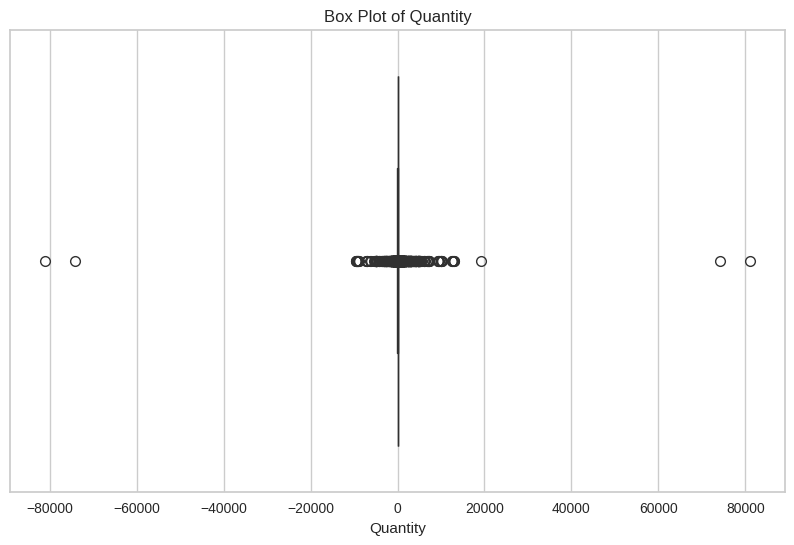

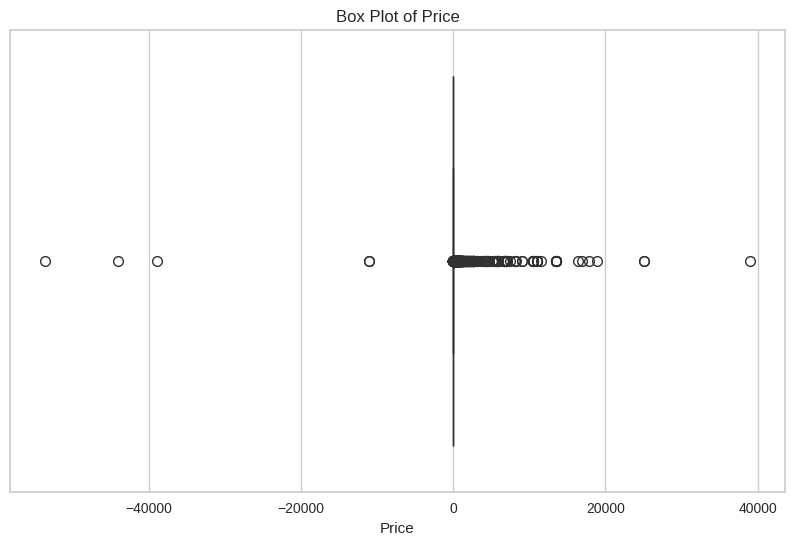

In [ ]:
for feature in ["Quantity", "Price"]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")
    plt.show()

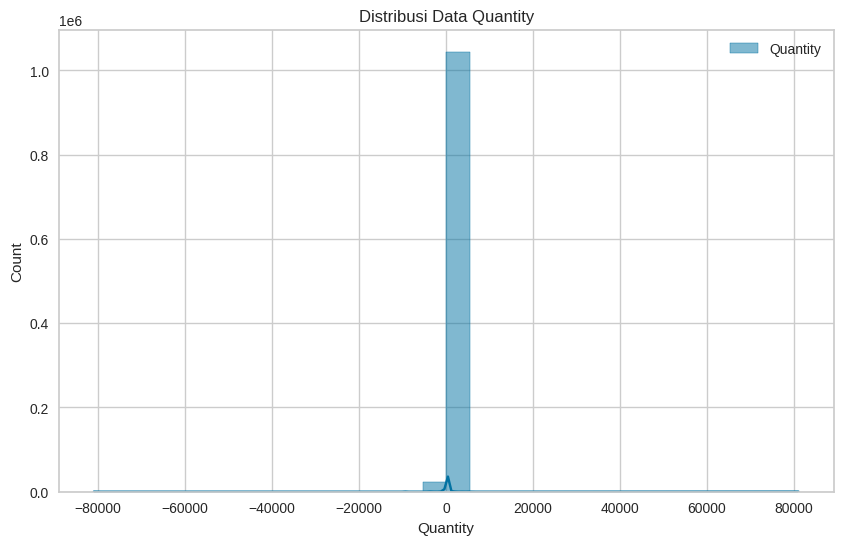

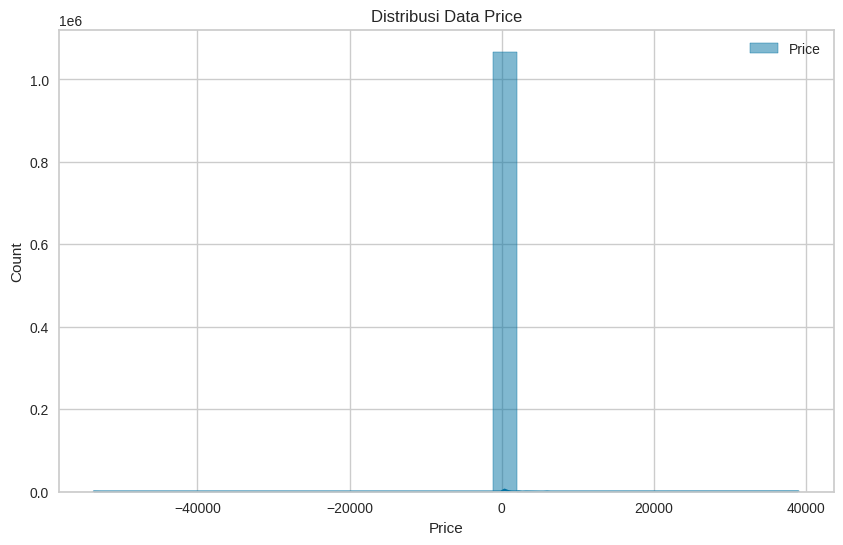

In [ ]:
for feature in ["Quantity", "Price"]:
  plt.figure(figsize=(10, 6))
  sns.histplot(df[feature], kde=True, label=feature, bins=30, element='step')
  plt.title(f'Distribusi Data {feature}')
  plt.legend()
  plt.show()

## EDA

<Axes: xlabel='Quantity', ylabel='Description'>

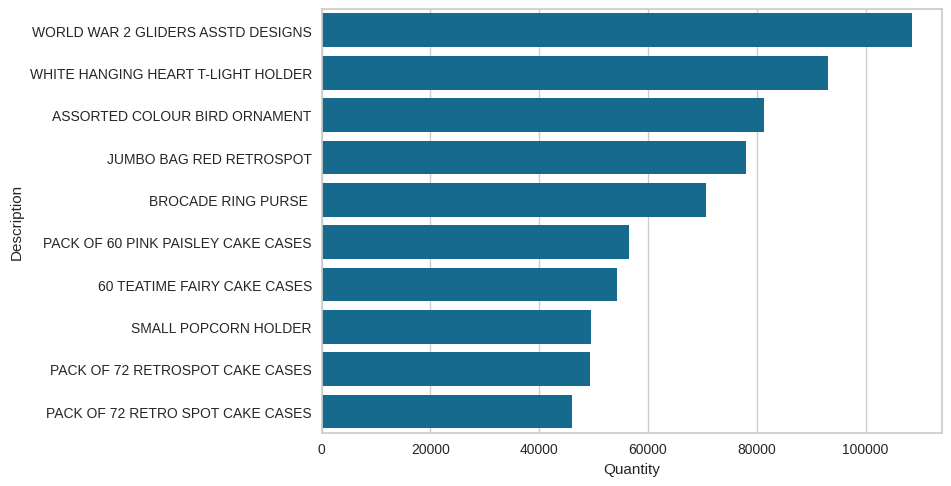

In [ ]:
top_product = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)

sns.barplot(top_product, orient="h")

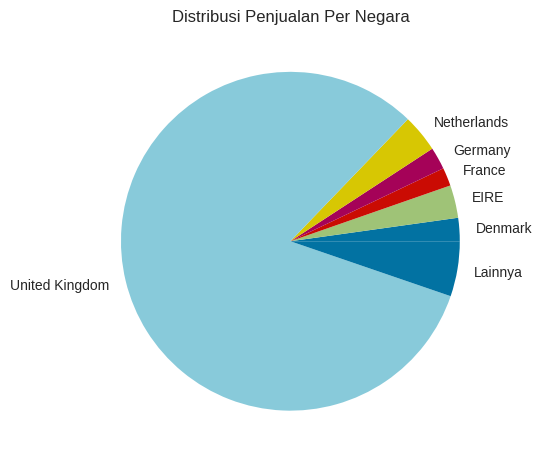

In [ ]:
country_quantity = df.groupby("Country")["Quantity"].sum()
total_quantity = df["Quantity"].sum()

country_percentage = country_quantity / total_quantity

small = country_percentage[country_percentage <= 0.01]
others = country_percentage[country_percentage > 0.01]

all = pd.concat([
    others,
    pd.Series({
        "Lainnya": small.sum()
    })
])

plt.pie(all.values, labels=all.index)
plt.title('Distribusi Penjualan Per Negara')
plt.show()

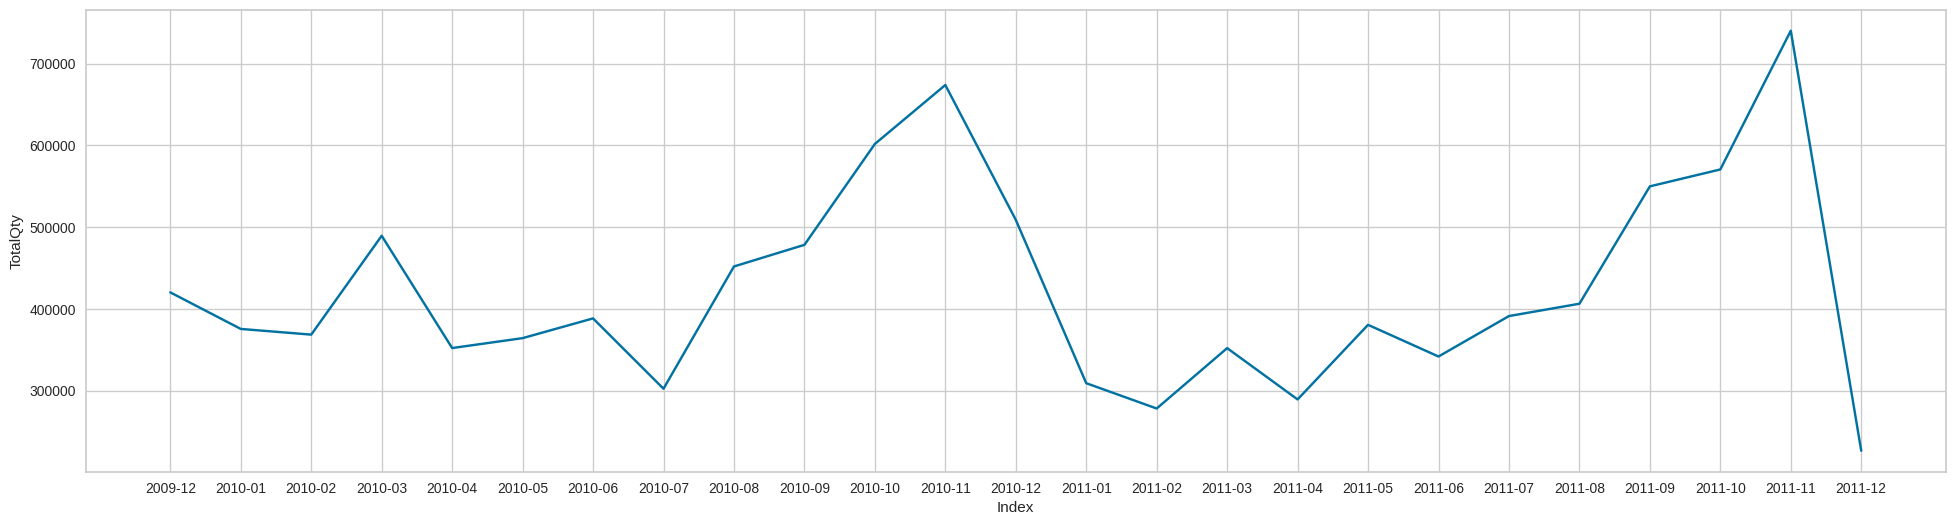

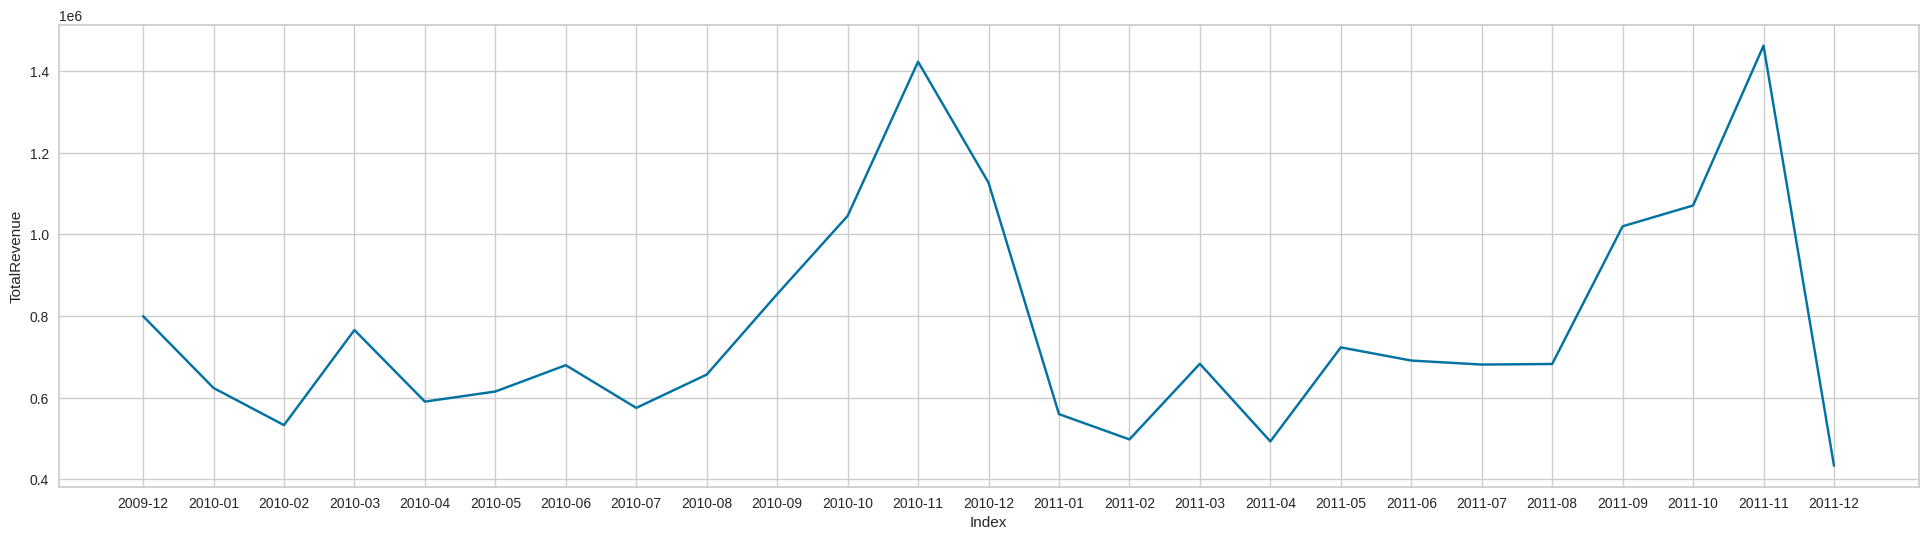

In [ ]:
df_year_month = df["InvoiceDate"].dt.to_period("M")

df_trend = df.assign(Revenue=df['Quantity'] * df['Price']).groupby(by=df_year_month).agg(
    TotalQty=("Quantity", "sum"),
    TotalRevenue=("Revenue", "sum")
).reset_index()
df_trend["Index"] = df_trend.index

plt.figure(figsize=(24, 6))
ax = sns.lineplot(data=df_trend, x="Index", y="TotalQty")
ax.set_xticks(df_trend['Index'], labels=df_trend["InvoiceDate"])
plt.show()

plt.figure(figsize=(24, 6))
ax = sns.lineplot(data=df_trend, x="Index", y="TotalRevenue")
ax.set_xticks(df_trend['Index'], labels=df_trend["InvoiceDate"])
plt.show()


# Data Preparation

## Data Cleaning

In [ ]:
df_clean = df.dropna(subset=["Customer ID"])

In [ ]:
df_clean = df_clean.drop_duplicates()

In [ ]:
invoice_str = df_clean["Invoice"].astype(str)
df_clean = df_clean[~invoice_str.str.startswith(('A', 'C'))]

In [ ]:
df_clean["Invoice"].astype(str).str.replace(r"\d", "_", regex=True).value_counts()

,count
Invoice,
______,779495


In [ ]:
df_clean = df_clean[~df_clean["StockCode"].isin([
    'D', 'POST', 'M', 'BANK CHARGES', 'ADJUST', 'PADS', 'DOT', 'AMAZONFEE', 'CRUK'
])]
df_clean = df_clean[~df_clean["StockCode"].astype(str).str.startswith(('TEST', 'SP', 'ADJUST', 'C'))]

In [ ]:
df_clean.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
display(df_clean["StockCode"].astype(str).str.replace(r"\d", "_", regex=True).unique())

array(['_____', '_____P', '_____W', '_____C', '_____B', '_____F',
       '_____L', '_____S', '_____A', '_____N', '_____E', '_____J',
       '_____D', '_____G', '_____LP', '_____BL', '_____K', '_____H',
       '_____M', '_____U', '_____GR', '_____R', '_____V', '_____T',
       '_____I', '_____O', '_____Z', '_____Y'], dtype=object)

In [ ]:
df_clean = df_clean[df_clean["Price"] != 0]

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 776577 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      776577 non-null  object        
 1   StockCode    776577 non-null  object        
 2   Description  776577 non-null  object        
 3   Quantity     776577 non-null  int64         
 4   InvoiceDate  776577 non-null  datetime64[ns]
 5   Price        776577 non-null  float64       
 6   Customer ID  776577 non-null  float64       
 7   Country      776577 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 53.3+ MB


In [ ]:
df_clean.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,776577.000000,776577,776577.000000,776577.000000
mean,13.519243,2011-01-03 00:44:11.290393600,2.934561,15326.605797
min,1.000000,2009-12-01 07:45:00,0.030000,12346.000000
25%,2.000000,2010-07-02 14:15:00,1.250000,13979.000000
50%,6.000000,2010-12-02 13:49:00,1.950000,15253.000000
75%,12.000000,2011-08-01 13:31:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,146.096695,NaN,4.293610,1692.861742


## Feature Engineering

In [ ]:
snapshot_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Snapshot date {snapshot_date}")

Snapshot date 2011-12-10 12:50:00


In [ ]:
df_rfm = df_clean.assign(
    TotalPrice=df_clean['Quantity'] * df_clean['Price']
).groupby("Customer ID").agg(
    Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency=("Invoice", "nunique"),
    Monetary=("TotalPrice", "sum")
).reset_index()
df_rfm.head(5)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,3,77352.96
1,12347.0,2,8,4921.53
2,12348.0,75,5,1658.40
3,12349.0,19,3,3678.69
4,12350.0,310,1,294.40


In [ ]:
df_rfm_model = df_rfm.drop(columns=["Customer ID"])

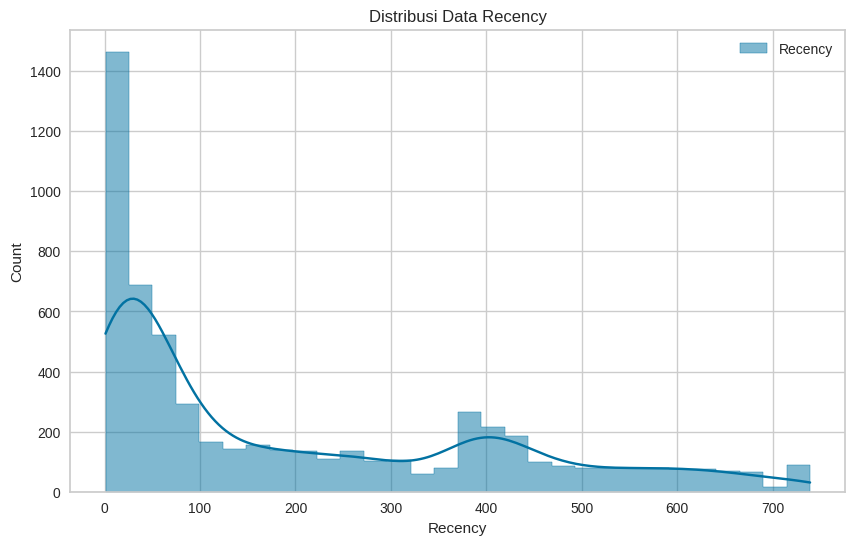

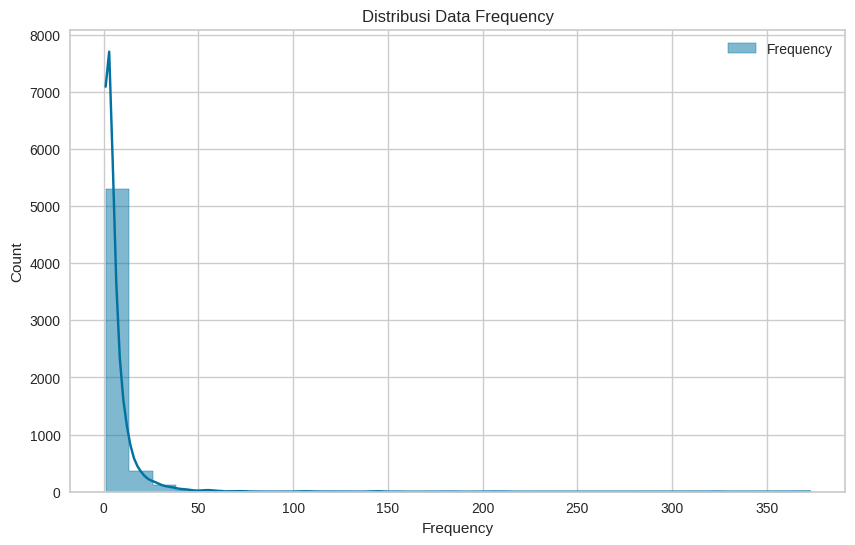

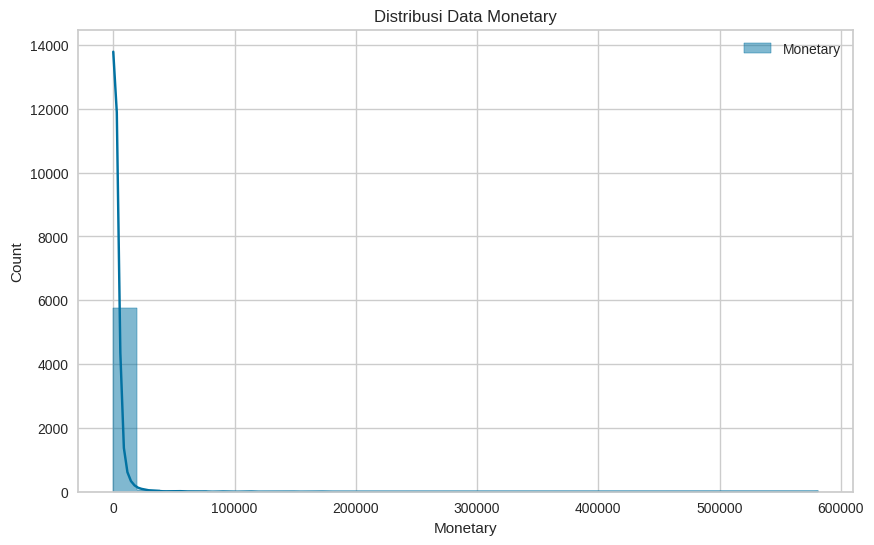

In [ ]:
for feature in df_rfm_model.columns:
  plt.figure(figsize=(10, 6))
  sns.histplot(df_rfm[feature], kde=True, label=feature, bins=30, element='step')
  plt.title(f'Distribusi Data {feature}')
  plt.legend()
  plt.show()

In [ ]:
from scipy import stats

scaler = StandardScaler()
# scaler = RobustScaler()
df_rfm_scaled = df_rfm_model.copy()
features = df_rfm_scaled.columns.tolist()
# for column in features:
df_rfm_scaled["Recency"] = stats.boxcox(df_rfm_scaled["Recency"])[0]
df_rfm_scaled["Frequency"] = stats.boxcox(df_rfm_scaled["Frequency"])[0]
df_rfm_scaled["Monetary"] = stats.boxcox(df_rfm_scaled["Monetary"])[0]
# df_rfm_scaled["Monetary"] = np.log1p(df_rfm_scaled["Monetary"])
df_rfm_scaled[features] = scaler.fit_transform(df_rfm_scaled[features])

In [ ]:
df_rfm_scaled.describe()

,Recency,Frequency,Monetary
count,5.852000e+03,5.852000e+03,5.852000e+03
mean,2.464801e-16,1.985197e-16,2.331241e-16
std,1.000085e+00,1.000085e+00,1.000085e+00
min,-2.040649e+00,-1.300692e+00,-4.819642e+00
25%,-8.398618e-01,-1.300692e+00,-6.915675e-01
50%,-6.468622e-02,3.800725e-02,-1.842846e-03
75%,9.908570e-01,8.262864e-01,6.808917e-01
max,1.615116e+00,2.820631e+00,4.006819e+00


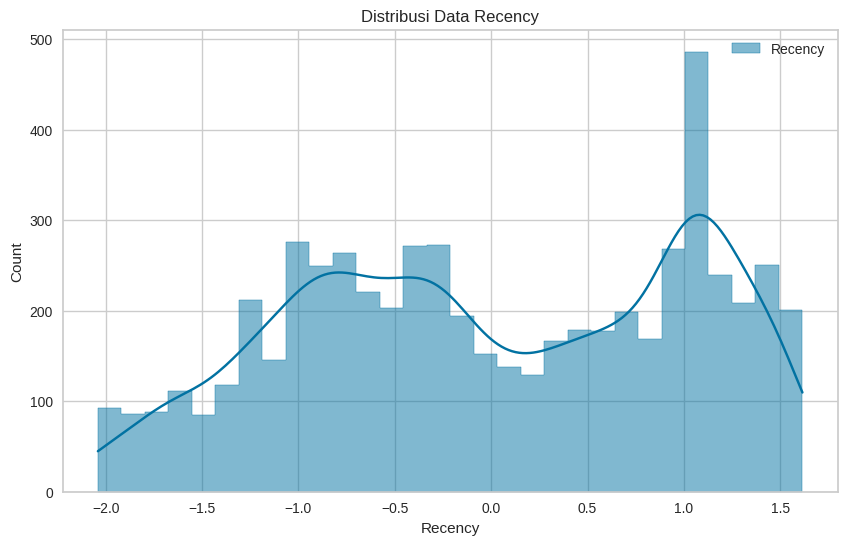

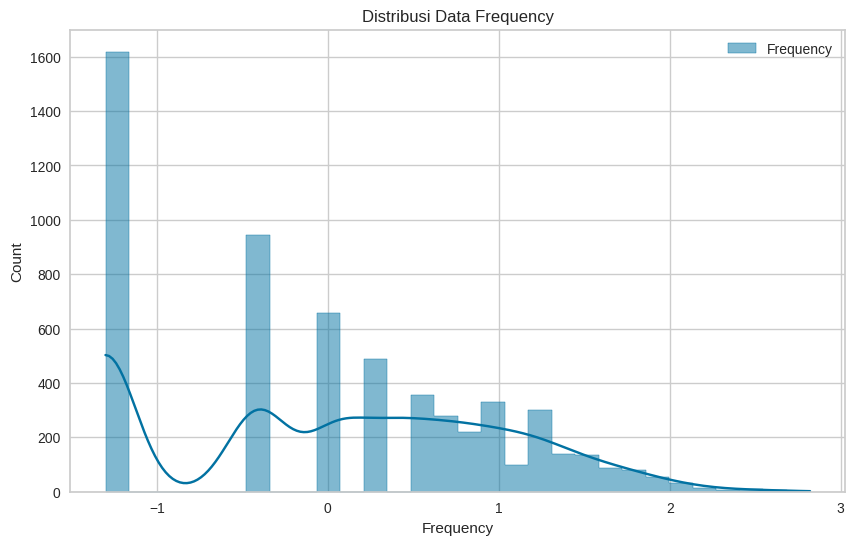

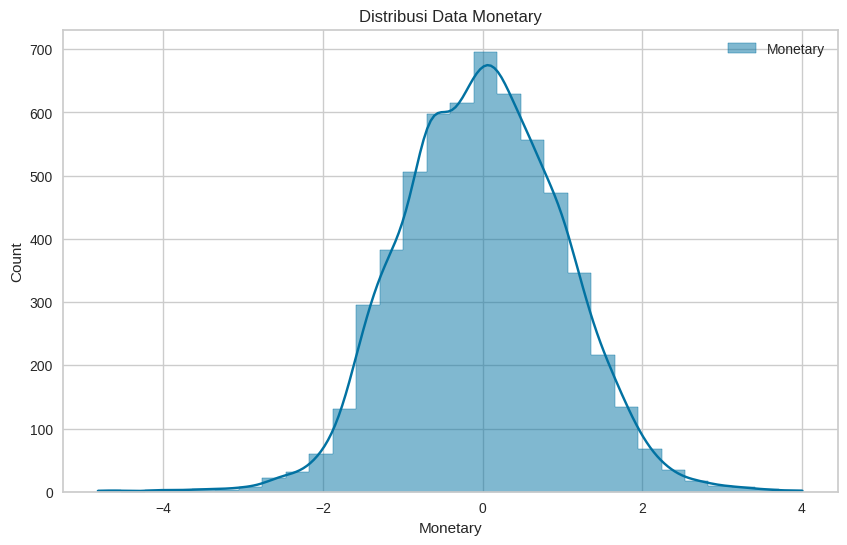

In [ ]:
for feature in df_rfm_scaled.columns:
  plt.figure(figsize=(10, 6))
  sns.histplot(df_rfm_scaled[feature], kde=True, label=feature, bins=30, element='step')
  plt.title(f'Distribusi Data {feature}')
  plt.legend()
  plt.show()

# Modelling

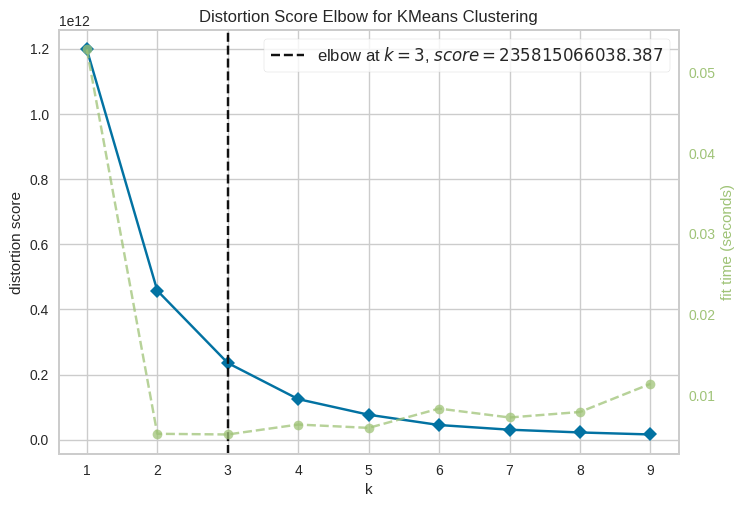

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(1, 10))
visualizer.fit(df_rfm_model)
visualizer.show()

In [ ]:
# kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_rfm_model)

KMeans(n_clusters=4, random_state=42)

In [ ]:
score = silhouette_score(df_rfm_model, kmeans.labels_)
score

np.float64(0.9534274395885176)

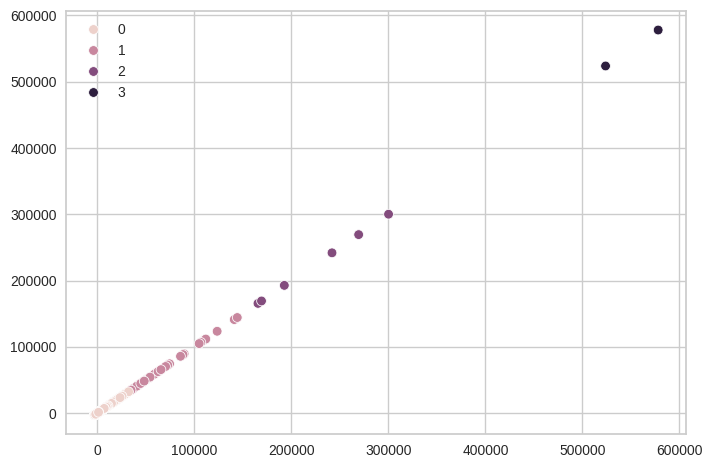

In [ ]:
pca = PCA(n_components=2,random_state=42)
x_std_pca = pca.fit_transform(df_rfm_model)

plt.figure()
sns.scatterplot(x=x_std_pca[:, 0], y=x_std_pca[:, 0], hue=kmeans.labels_)
plt.show()

In [ ]:
df_rfm["Cluster"] = kmeans.labels_
grouped_cluster = df_rfm.groupby("Cluster")
for column in df_rfm.columns:
  if (column == "Customer ID") | (column == "Cluster"): continue
  display(column)
  display(grouped_cluster[column].describe())

'Recency'

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,5809.0,201.331554,208.673417,1.0,26.00,96.0,380.00,739.0
1,35.0,56.971429,113.527785,1.0,2.00,7.0,23.00,372.0
2,6.0,4.500000,3.728270,1.0,1.50,3.5,7.00,10.0
3,2.0,1.500000,0.707107,1.0,1.25,1.5,1.75,2.0


'Frequency'

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,5809.0,5.634705,8.040776,1.0,1.00,3.0,7.00,184.0
1,35.0,79.971429,70.193634,3.0,31.50,58.0,106.50,322.0
2,6.0,128.833333,131.856614,2.0,53.25,101.5,143.75,373.0
3,2.0,145.000000,0.000000,145.0,145.00,145.0,145.00,145.0


'Monetary'

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,5809.0,2085.302352,3605.780126,2.95,337.040,844.86,2180.760,36398.65
1,35.0,71170.144857,30752.067645,37642.48,49406.025,57215.33,89903.505,147142.77
2,6.0,226058.830000,55793.696638,168472.50,178009.825,220212.47,265385.655,303069.88
3,2.0,553869.280000,38350.303973,526751.52,540310.400,553869.28,567428.160,580987.04


Cluster,0,1,2,3
Recency,1.0,0.277591,0.015013,0.0
Frequency,0.0,0.533395,0.883998,1.0
Monetary,0.0,0.125203,0.405908,1.0


<Axes: title={'center': 'Snake Plot Cluster'}>

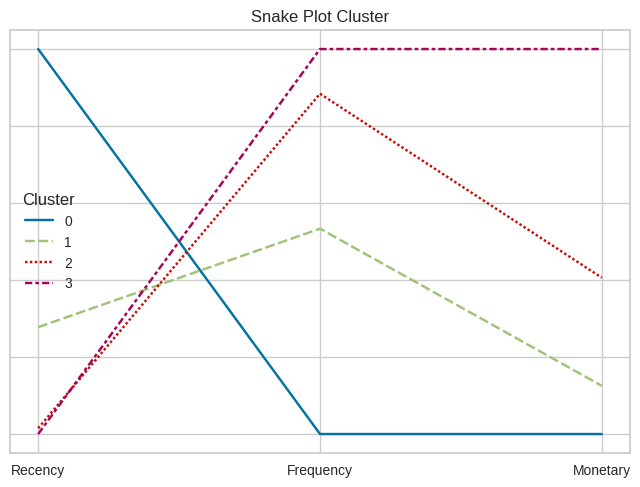

In [ ]:
df_rfm_scaled["Cluster"] = kmeans.labels_
data_snake = df_rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean"
})
features = ["Recency", "Frequency", "Monetary"]
data_snake[features] = MinMaxScaler().fit_transform(data_snake[features])
display(data_snake.T)
ax = sns.lineplot(data_snake.T)
ax.set_yticklabels([])
ax.set_title("Snake Plot Cluster")
ax

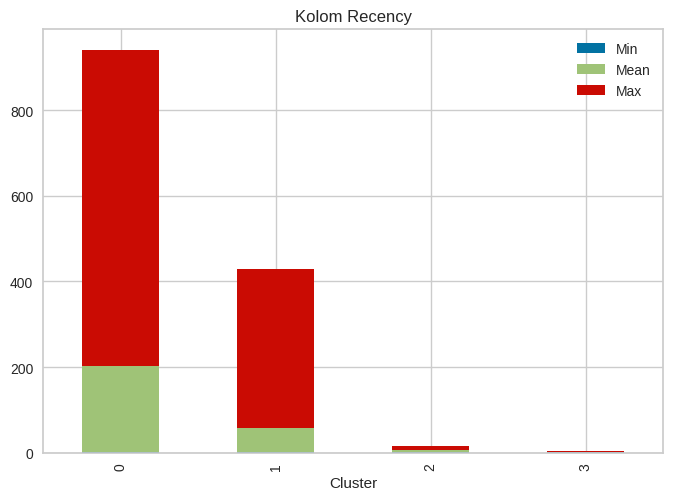

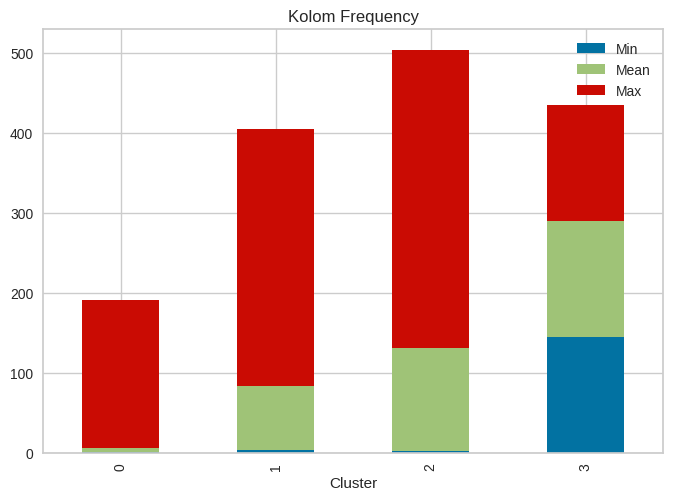

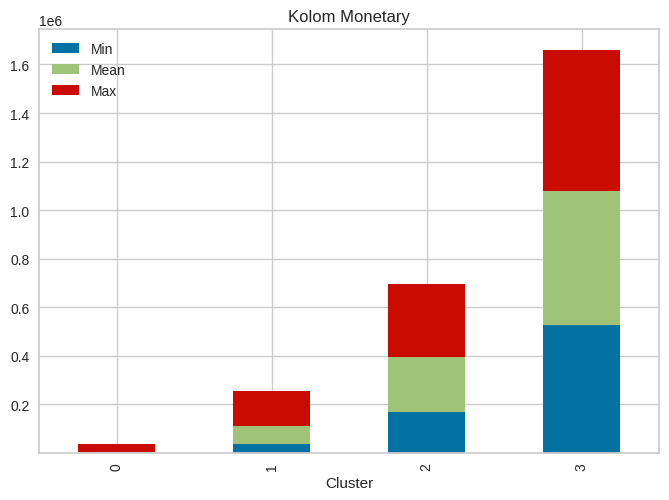

In [ ]:
grouped_cluster = df_rfm.groupby("Cluster")
for column in df_rfm.columns:
  if (column == "Customer ID") | (column == "Cluster"): continue
  column_data = grouped_cluster.agg(
      Min=(column, "min"),
      Mean=(column, "mean"),
      Max=(column, "max"),
  )
  column_data.plot(kind='bar', stacked=True)

  plt.title(f"Kolom {column}")
  plt.show()

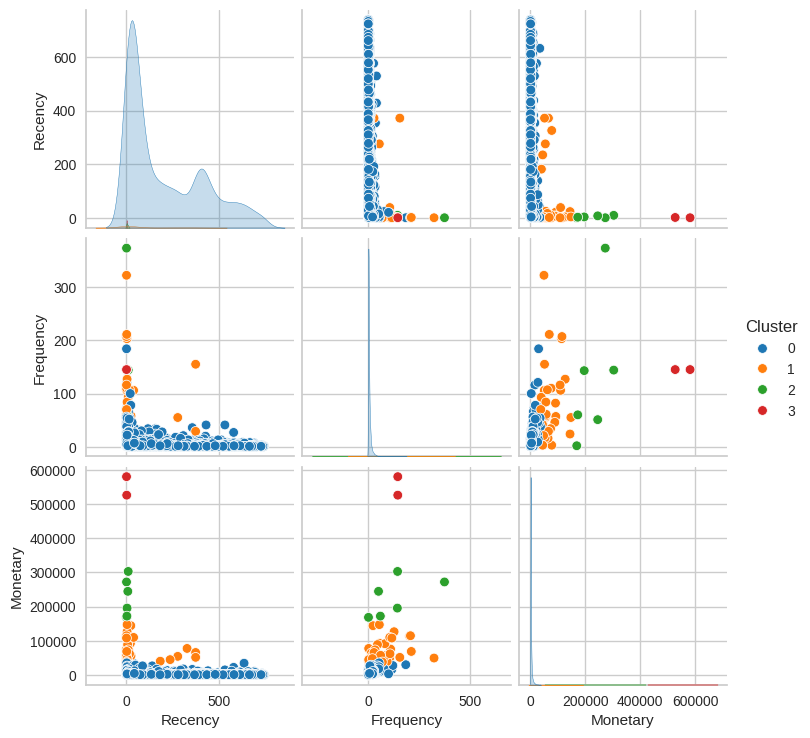

In [ ]:
sns.pairplot(df_rfm, vars=['Recency','Frequency','Monetary'], hue='Cluster', palette='tab10')
plt.show()